In [1]:
# !gdown 1MmJtib8_P0i5kMrIyEfdgDH_Okwlr8aY #download dataset

In [2]:
# Import Library
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import nltk
import random
import string
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, GlobalMaxPool1D, Bidirectional, Conv1D, MaxPooling1D, Bidirectional, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten, Dense, GlobalMaxPool1D

In [3]:
with open('waste_management3.json', encoding='utf-8') as content:
  data = json.load(content)

In [4]:
# Package sentence tokenizer
nltk.download('punkt')
# Package lemmatization
nltk.download('wordnet')
# Package multilingual wordnet data
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\biman\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\biman\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\biman\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [5]:
# Mendapatkan semua data ke dalam list
tags = [] # data tag
inputs = [] # data input atau pattern
responses = {} # data respon
words = [] # Data kata
classes = [] # Data Kelas atau Tag
documents = [] # Data Kalimat Dokumen
ignore_words = ['?', '!'] # Mengabaikan tanda spesial karakter

for intent in data['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['patterns']:
    inputs.append(lines)
    tags.append(intent['tag'])
    for pattern in intent['patterns']:
      w = nltk.word_tokenize(pattern)
      words.extend(w)
      documents.append((w, intent['tag']))
      # add to our classes list
      if intent['tag'] not in classes:
        classes.append(intent['tag'])

# Konversi data json ke dalam dataframe
# data = pd.DataFrame({"patterns":inputs, "tags":tags})

In [6]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(inputs, tags,test_size=0.2, random_state=42)

# Konversi data ke dalam dataframe
train_data = pd.DataFrame({"patterns": X_train, "tags": y_train})
test_data = pd.DataFrame({"patterns": X_test, "tags": y_test})

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   patterns  189 non-null    object
 1   tags      189 non-null    object
dtypes: object(2)
memory usage: 3.1+ KB


In [8]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   patterns  48 non-null     object
 1   tags      48 non-null     object
dtypes: object(2)
memory usage: 896.0+ bytes


In [9]:
train_data.head()

,patterns,tags
0,Apa manfaat dari pengolahan limbah sampah?,manfaat_pengolahan_limbah_sampah
1,Apa itu pengolahan limbah kaca?,pengolahan_limbah_kaca
2,Berikan penjelasan nilai yang dihasilkan dari ...,nilai_pengolahan_kaca
3,jelaskan langkah dalam pengolahan limbah?,langkah_pengolahan_limbah
4,Bagaimana cara menghasilkan biogas dari limbah?,pengolahan_biogas


In [10]:
test_data.head()

,patterns,tags
0,apa daur ulang limbah sampah itu penting? kena...,pentingnya_daur_ulang
1,chatbotx,greeting
2,Manfaat dari pengolahan limbah kaca apa saja?,manfaat_pengolahan_kaca
3,berikan jenis atau contoh limbah sampah yang b...,jenis_sampah_daur_ulang
4,pagi,greeting


In [11]:
train_data['patterns'] = train_data['patterns'].apply(lambda wrd: [ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
train_data['patterns'] = train_data['patterns'].apply(lambda wrd: ''.join(wrd))
test_data['patterns'] = test_data['patterns'].apply(lambda wrd: [ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
test_data['patterns'] = test_data['patterns'].apply(lambda wrd: ''.join(wrd))

In [12]:
# Inisialisasi Lemmatizer
lemmatizer = WordNetLemmatizer()

# Fungsi untuk melakukan lemmatization pada kata-kata dalam kalimat
def lemmatize_text(text):
    tokens = nltk.word_tokenize(text)  # Tokenisasi kata-kata dalam kalimat
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Lemmatization
    lemmatized_text = ' '.join(lemmatized_tokens)  # Menggabungkan kembali kata-kata menjadi kalimat
    return lemmatized_text

# Contoh penggunaan fungsi lemmatize_text pada dataset
train_data['patterns'] = train_data['patterns'].apply(lemmatize_text)
test_data['patterns'] = test_data['patterns'].apply(lemmatize_text)

In [13]:
# Tokenize the data (Tokenisasi Data)
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(train_data['patterns'])

x_train = tokenizer.texts_to_sequences(train_data['patterns'])
x_test = tokenizer.texts_to_sequences(test_data['patterns'])

In [14]:
# Apply padding
max_sequence_length = max(len(seq) for seq in x_train + x_test)
x_train = pad_sequences(x_train, maxlen=max_sequence_length)
x_test = pad_sequences(x_test, maxlen=max_sequence_length)

In [15]:
# Combine tags from train_data and test_data
all_tags = list(set(train_data['tags']) | set(test_data['tags']))

# Encoding the outputs
le = LabelEncoder()
le.fit(all_tags)

y_train = le.transform(train_data['tags'])
y_test = le.transform(test_data['tags'])

In [16]:
# Splitting the dataset
train_dataset = (x_train, y_train)
test_dataset = (x_test, y_test)

In [17]:
# Creating the model
# Menambahkan regularisasi L2
regularization = regularizers.l2(0.01)

# Mengubah tingkat dropout menjadi 0.5
dropout_rate = 0.5

# Mendefinisikan input layer
i = Input(shape=(max_sequence_length,))

# Embedding layer
embedding_size = 100
x = Embedding(len(tokenizer.word_index) + 1, embedding_size)(i)

# Bidirectional LSTM layer
lstm_units = 32
x = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)

# Bidirectional GRU layer
gru_units = 64
x = Bidirectional(GRU(gru_units, return_sequences=True))(x)

# Flatten layer
x = Flatten()(x)

# Dense layer with L2 regularization
dense_units = 50
x = Dense(dense_units, activation='relu', kernel_regularizer=regularization)(x)
x = Dropout(dropout_rate)(x)

# Output layer
num_classes = len(classes)
x = Dense(num_classes, activation="softmax")(x)
model = Model(i, x)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16)]              0         
                                                                 
 embedding (Embedding)       (None, 16, 100)           16600     
                                                                 
 bidirectional (Bidirectiona  (None, 16, 64)           34048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 16, 128)          49920     
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 50)                102450

In [18]:
class myCallback(tf.keras.callbacks.Callback):
    # Define the method that checks the accuracy at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.8:
            print("\nReached 0.7 val acc so cancelling training!")

            # Stop training once the above condition is met
            self.model.stop_training = True

In [19]:
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
# Instantiate the callback class
cb = myCallback()

In [20]:
# Compiling the model
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

In [21]:
# Training the model
batch_size=32
history = model.fit(train_dataset[0], train_dataset[1], epochs=500, callbacks = [cb], validation_data=test_dataset)

Epoch 1/500
6/6 [==============================] - 9s 310ms/step - loss: 4.4740 - accuracy: 0.0265 - val_loss: 4.3144 - val_accuracy: 0.0625
Epoch 2/500
6/6 [==============================] - 0s 28ms/step - loss: 4.2185 - accuracy: 0.0212 - val_loss: 4.1071 - val_accuracy: 0.0417
Epoch 3/500
6/6 [==============================] - 0s 24ms/step - loss: 4.0135 - accuracy: 0.0476 - val_loss: 3.9569 - val_accuracy: 0.0417
Epoch 4/500
6/6 [==============================] - 0s 23ms/step - loss: 3.8619 - accuracy: 0.0529 - val_loss: 3.8405 - val_accuracy: 0.0417
Epoch 5/500
6/6 [==============================] - 0s 23ms/step - loss: 3.7378 - accuracy: 0.0370 - val_loss: 3.7256 - val_accuracy: 0.0625
Epoch 6/500
6/6 [==============================] - 0s 23ms/step - loss: 3.6161 - accuracy: 0.0635 - val_loss: 3.5881 - val_accuracy: 0.0417
Epoch 7/500
6/6 [==============================] - 0s 23ms/step - loss: 3.4595 - accuracy: 0.0952 - val_loss: 3.4566 - val_accuracy: 0.0417
Epoch 8/500
6/6 [==

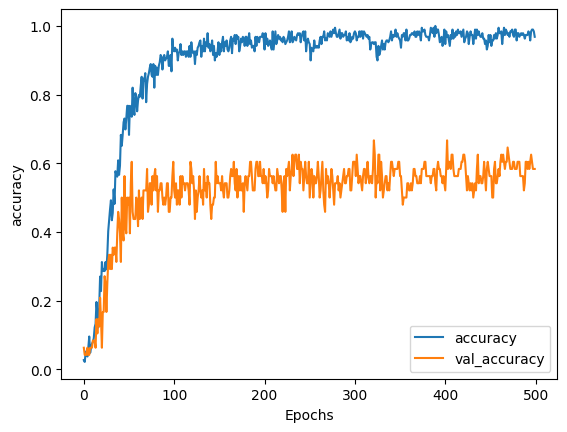

In [22]:
#diisi dengan plot hasil accuray dan loss training dan testing


# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy
plot_graphs(history, "accuracy")

In [23]:
model.save('model.h5', history)
print("model created")

model created


In [24]:
# # Membuat Input Chat
# while True:
#   texts_p = []
#   prediction_input = input('👨‍🦰 Kamu : ')

#   # Menghapus punktuasi dan konversi ke huruf kecil
#   prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
#   prediction_input = ''.join(prediction_input)
#   texts_p.append(prediction_input)

#   # Tokenisasi dan Padding
#   prediction_input = tokenizer.texts_to_sequences(texts_p)
#   prediction_input = np.array(prediction_input).reshape(-1)
#   prediction_input = pad_sequences([prediction_input],max_sequence_length)

#   # Mendapatkan hasil keluaran pada model
#   output = model.predict(prediction_input)
#   output = output.argmax()

#   # Menemukan respon sesuai data tag
#   response_tag = le.inverse_transform([output])[0]
#   print("🤖 ChatbotX :",random.choice(responses[response_tag]))
#   if response_tag == "goodbye":
#     break

In [25]:
# #diisi dengan save model h5 dan converter tflite
# import joblib

In [26]:
# # Save the model to a file
# joblib.dump(model, 'chatbot_model.pkl')

In [27]:
# # Save the model to a file
# joblib.dump(history, 'history_model.pkl')

In [28]:
# # Load the model from the file
# chatbot_model = joblib.load('chatbot_model.pkl')

In [29]:
# print(chatbot_model.summary())

In [30]:
# # Membuat Input Chat
# while True:
#   texts_p = []
#   prediction_input = input('👨‍🦰 Kamu : ')

#   # Menghapus punktuasi dan konversi ke huruf kecil
#   prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
#   prediction_input = ''.join(prediction_input)
#   texts_p.append(prediction_input)

#   # Tokenisasi dan Padding
#   prediction_input = tokenizer.texts_to_sequences(texts_p)
#   prediction_input = np.array(prediction_input).reshape(-1)
#   prediction_input = pad_sequences([prediction_input],max_sequence_length)

#   # Mendapatkan hasil keluaran pada model
#   output = chatbot_model.predict(prediction_input)
#   output = output.argmax()

#   # Menemukan respon sesuai data tag
#   response_tag = le.inverse_transform([output])[0]
#   print("🤖 ChatbotX :",random.choice(responses[response_tag]))
#   if response_tag == "goodbye":
#     break

In [31]:
# from flask import Flask, render_template, request
# import numpy as np
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# import random
# import string

# app = Flask(__name__)

# # Define your model and tokenizer here
# # chatbot_model = 'chatbot_model'
# # tokenizer = ''
# # max_sequence_length = ''
# # le = ''
# # responses = ''

# @app.route('/')
# def home():
#     return "hey"

# @app.route('/chat', methods=['POST'])
# def chat():
#     texts_p = []
#     prediction_input = request.form['message']

#     # Remove punctuation and convert to lowercase
#     prediction_input = [letter.lower() for letter in prediction_input if letter not in string.punctuation]
#     prediction_input = ''.join(prediction_input)
#     texts_p.append(prediction_input)

#     # Tokenize and pad the input
#     prediction_input = tokenizer.texts_to_sequences(texts_p)
#     prediction_input = np.array(prediction_input).reshape(-1)
#     prediction_input = pad_sequences([prediction_input], max_sequence_length)

#     # Get the model's output prediction
#     output = chatbot_model.predict(prediction_input)
#     output = output.argmax()

#     # Find the corresponding response based on the predicted tag
#     response_tag = le.inverse_transform([output])[0]
#     response = random.choice(responses[response_tag])

#     return {'response': response}

# if __name__ == '__main__':
#     app.run()
